In [2]:
import import_ipynb
import data_preprocessing

# Update the path to the correct location of the file
file_path = '.'

# Now you can use functions and variables from data_preprocessing
# For example, if data_preprocessing has a function named preprocess_data, you can call it like this:
# processed_data = data_preprocessing.preprocess_data(raw_data)

In [3]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


#### I still don't understand anythig ; but it looks better ...

### Code from josh_models.ipynb


In [4]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

It looks like you have multiple DataFrames related to different operational modes and time periods of a system, possibly a power plant or similar industrial setup. Each DataFrame contains a variety of sensor readings and operational parameters.

Here's a brief summary of each DataFrame:

1. **u6_s01_equil_pump**: 
    - Entries: 24,666
    - Columns: 103
    - Time Period: 2021-06-02 to 2021-07-30
    - Contains various sensor readings and operational parameters, including `tot_activepower`, `ext_tmp`, `plant_tmp`, `charge`, `coupler_position`, `pump_calculated_flow`, `pump_pressure_diff`, `pump_rotspeed`, `tot_current`, `turbine_pressure`, `turbine_rotspeed`, and many more.

2. **u6_s01_equil_turbine**:
    - Entries: 54,713
    - Columns: 103
    - Time Period: 2021-06-01 to 2021-07-30
    - Similar structure to `u6_s01_equil_pump`, with additional readings related to turbine operations.

3. **u6_s02_equil_pump**:
    - Entries: 23,725
    - Columns: 103
    - Time Period: 2021-12-09 to 2021-12-30
    - Contains similar sensor readings and operational parameters as the previous DataFrames, but for a different time period.

4. **u6_s02_equil_turbine**:
    - Entries: 55,526
    - Columns: 103
    - Time Period: 2021-11-02 to 2021-12-30
    - Similar structure to `u6_s02_equil_pump`, with additional turbine-related readings.

5. **u6_test_equil_pump**:
    - Entries: 40,318
    - Columns: 99
    - Time Period: 2021-01-03 to 2021-03-30
    - Contains sensor readings and operational parameters for testing purposes.

6. **u6_test_equil_turbine**:
    - Entries: 74,312
    - Columns: 99
    - Time Period: 2021-01-01 to 2021-03-30
    - Similar structure to `u6_test_equil_pump`, with additional turbine-related readings.

7. **u6_train_equil_pump**:
    - Entries: 133,468
    - Columns: 99
    - Time Period: 2020-01-02 to 2020-12-26
    - Contains sensor readings and operational parameters for training purposes.

8. **u6_train_equil_turbine**:
    - Entries: 335,084
    - Columns: 99
    - Time Period: 2020-01-05 to 2020-12-30
    - Similar structure to `u6_train_equil_pump`, with additional turbine-related readings.

Each DataFrame includes a variety of sensor readings and operational parameters, such as temperatures, pressures, flow rates, voltages, currents, and other relevant metrics. These DataFrames can be used for analysis, monitoring, and potentially for training machine learning models to predict anomalies or optimize operations.

## Import Dependencies :

In [5]:
# Install essential libraries for deep learning and data processing
%pip install torch torchvision numpy tqdm

# Install libraries for audio analysis and feature extraction
%pip install librosa

# Install libraries for visualization and plotting
%pip install matplotlib

# Install libraries for machine learning metrics
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


## Define Auto Encoder


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Simplified Autoencoder
class FastAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(FastAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

# Data preprocessing
def preprocess_data_fast(df):
    # Scale data and convert to tensor
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    return torch.tensor(scaled_data, dtype=torch.float32), scaler

# Optimized training loop
def train_autoencoder_fast(model, train_data, val_data, epochs=20, batch_size=32, learning_rate=0.005):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                reconstruction, _ = model(batch)
                loss = criterion(reconstruction, batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return model

# Preprocess u4_train_equil_turbine
u4_train_data, scaler = preprocess_data_fast(u4_train_equil_turbine)

# Train-validation split
train_tensor, val_tensor = train_test_split(u4_train_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u4_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


Epoch 1/20, Train Loss: 0.0414, Validation Loss: 0.0193
Epoch 2/20, Train Loss: 0.0173, Validation Loss: 0.0161
Epoch 3/20, Train Loss: 0.0149, Validation Loss: 0.0139
Epoch 4/20, Train Loss: 0.0132, Validation Loss: 0.0123
Epoch 5/20, Train Loss: 0.0128, Validation Loss: 0.0114
Epoch 6/20, Train Loss: 0.0115, Validation Loss: 0.0114
Epoch 7/20, Train Loss: 0.0109, Validation Loss: 0.0102
Epoch 8/20, Train Loss: 0.0110, Validation Loss: 0.0091
Epoch 9/20, Train Loss: 0.0111, Validation Loss: 0.0092
Epoch 10/20, Train Loss: 0.0120, Validation Loss: 0.0090
Epoch 11/20, Train Loss: 0.0099, Validation Loss: 0.0109
Epoch 12/20, Train Loss: 0.0105, Validation Loss: 0.0129
Epoch 13/20, Train Loss: 0.0097, Validation Loss: 0.0118
Epoch 14/20, Train Loss: 0.0104, Validation Loss: 0.0083
Epoch 15/20, Train Loss: 0.0090, Validation Loss: 0.0141
Epoch 16/20, Train Loss: 0.0093, Validation Loss: 0.0098
Epoch 17/20, Train Loss: 0.0093, Validation Loss: 0.0082
Epoch 18/20, Train Loss: 0.0102, Validat

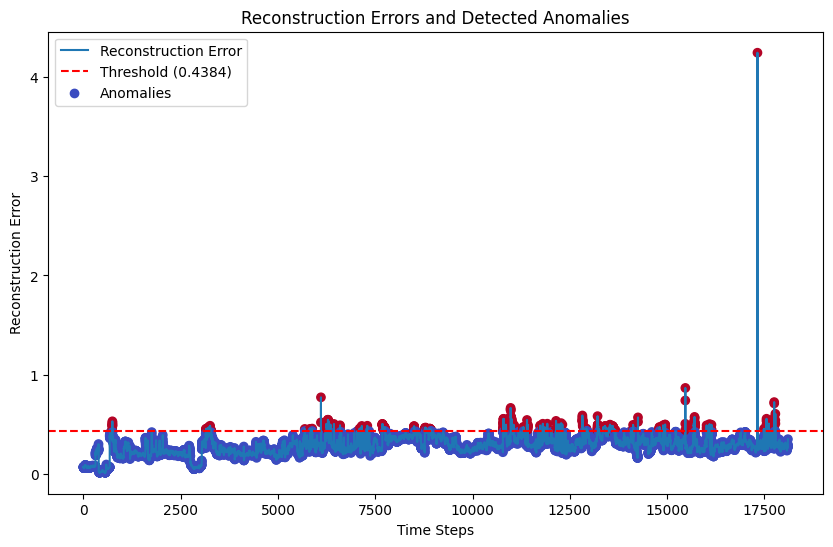

In [20]:
# Preprocess the test data
def preprocess_test_data(test_df, train_columns, scaler):
    # Reindex test_df to match the columns of the training data
    test_df = test_df.reindex(columns=train_columns, fill_value=0)
    # Use the same scaler from the training data
    scaled_test_data = scaler.transform(test_df)
    return torch.tensor(scaled_test_data, dtype=torch.float32)

# Evaluate reconstruction error
def evaluate_reconstruction(model, test_data):
    model.eval()
    with torch.no_grad():
        reconstruction, _ = model(test_data)
        reconstruction_error = torch.mean((reconstruction - test_data) ** 2, dim=1)
    return reconstruction_error



# Define anomaly score
def define_anomaly_score(reconstruction_errors, threshold=None):
    if threshold is None:
        threshold = torch.quantile(reconstruction_errors, 0.95)  # 95th percentile threshold
    anomaly_scores = (reconstruction_errors > threshold).int()
    return anomaly_scores, threshold

# Visualize reconstruction errors and anomalies
def visualize_anomalies(reconstruction_errors, anomaly_scores, threshold):
    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_errors.numpy(), label="Reconstruction Error")
    plt.axhline(y=threshold.item(), color='r', linestyle='--', label=f"Threshold ({threshold.item():.4f})")
    plt.scatter(
        range(len(anomaly_scores)), 
        reconstruction_errors.numpy(), 
        c=anomaly_scores.numpy(), 
        cmap='coolwarm', 
        label="Anomalies"
    )
    plt.title("Reconstruction Errors and Detected Anomalies")
    plt.xlabel("Time Steps")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.show()

# Example usage for u4_test_equil_turbine
# Assume `trained_model` is the autoencoder trained on u4_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u4_train_equil_turbine

# Preprocess test data
u4_test_data = preprocess_test_data(u4_test_equil_turbine, u4_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u4_turbine_trained_model, u4_test_data)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

In [23]:
print(anomaly_scores)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


## For  u4_train_equil_pump

In [21]:
# Preprocess u4_train_equil_pump
u4_train_pump_data, scaler = preprocess_data_fast(u4_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u4_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u4_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


Epoch 1/20, Train Loss: 0.0849, Validation Loss: 0.0368
Epoch 2/20, Train Loss: 0.0586, Validation Loss: 0.0772
Epoch 3/20, Train Loss: 0.0455, Validation Loss: 0.0703
Epoch 4/20, Train Loss: 0.0315, Validation Loss: 0.0233
Epoch 5/20, Train Loss: 0.0289, Validation Loss: 0.0263
Epoch 6/20, Train Loss: 0.0289, Validation Loss: 0.0217
Epoch 7/20, Train Loss: 0.0256, Validation Loss: 0.0268
Epoch 8/20, Train Loss: 0.0274, Validation Loss: 0.0244
Epoch 9/20, Train Loss: 0.0258, Validation Loss: 0.0238
Epoch 10/20, Train Loss: 0.0251, Validation Loss: 0.0219
Epoch 11/20, Train Loss: 0.0250, Validation Loss: 0.0290
Epoch 12/20, Train Loss: 0.0241, Validation Loss: 0.0208
Epoch 13/20, Train Loss: 0.0235, Validation Loss: 0.0201
Epoch 14/20, Train Loss: 0.0235, Validation Loss: 0.0302
Epoch 15/20, Train Loss: 0.0234, Validation Loss: 0.0262
Epoch 16/20, Train Loss: 0.0232, Validation Loss: 0.0220
Epoch 17/20, Train Loss: 0.0223, Validation Loss: 0.0243
Epoch 18/20, Train Loss: 0.0225, Validat

#### Train on test dataset

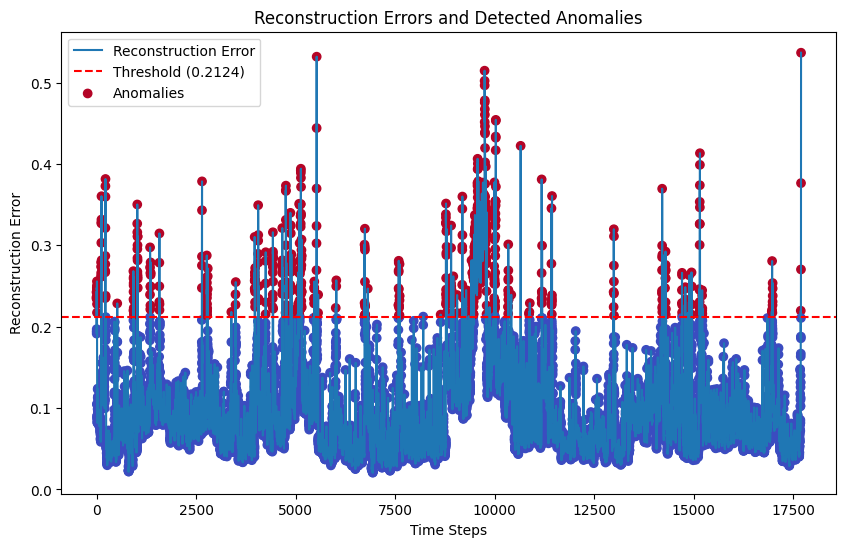

In [26]:
# Example usage for u4_test_equil_pump
# Assume `trained_model` is the autoencoder trained on u4_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u4_train_equil_pump

# Preprocess test data
u4_test_pump_data = preprocess_test_data(u4_test_equil_pump, u4_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u4_pump_trained_model, u4_test_pump_data)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## For u5_train_equil_turbine


In [28]:
# # Preprocess u5_train_equil_turbine
# u5_train_turbine_data, scaler = preprocess_data_fast(u5_train_equil_turbine)

# # Train-validation split
# train_tensor, val_tensor = train_test_split(u5_train_turbine_data, test_size=0.2, random_state=42)

# # Initialize and train the autoencoder
# input_dim = train_tensor.shape[1]
# model = FastAutoencoder(input_dim)
# u5_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

In [29]:

# Preprocess u5_train_equil_turbine with scaler validation
scaler = StandardScaler()  # Initialize scaler
u5_train_turbine_scaled = scaler.fit_transform(u5_train_equil_turbine)  # Fit scaler and transform data
u5_train_turbine_data = torch.tensor(u5_train_turbine_scaled, dtype=torch.float32)  # Convert to tensor

# Train-validation split
train_tensor, val_tensor = train_test_split(u5_train_turbine_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u5_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


Epoch 1/20, Train Loss: 0.0978, Validation Loss: 0.1013
Epoch 2/20, Train Loss: 0.1504, Validation Loss: 0.2665
Epoch 3/20, Train Loss: 0.1785, Validation Loss: 0.1589
Epoch 4/20, Train Loss: 0.1953, Validation Loss: 0.1890
Epoch 5/20, Train Loss: 0.1947, Validation Loss: 0.1869
Epoch 6/20, Train Loss: 0.1947, Validation Loss: 0.1877
Epoch 7/20, Train Loss: 0.1932, Validation Loss: 0.1856
Epoch 8/20, Train Loss: 0.1926, Validation Loss: 0.1857
Epoch 9/20, Train Loss: 0.1914, Validation Loss: 0.1857
Epoch 10/20, Train Loss: 0.1910, Validation Loss: 0.1854
Epoch 11/20, Train Loss: 0.1917, Validation Loss: 0.1853
Epoch 12/20, Train Loss: 0.1934, Validation Loss: 0.1866
Epoch 13/20, Train Loss: 0.1960, Validation Loss: 0.1865
Epoch 14/20, Train Loss: 0.1915, Validation Loss: 0.1885
Epoch 15/20, Train Loss: 0.1914, Validation Loss: 0.2085
Epoch 16/20, Train Loss: 0.1905, Validation Loss: 0.1851
Epoch 17/20, Train Loss: 0.2248, Validation Loss: 0.1984
Epoch 18/20, Train Loss: 0.2929, Validat

#### for synthetic anomalies : s01

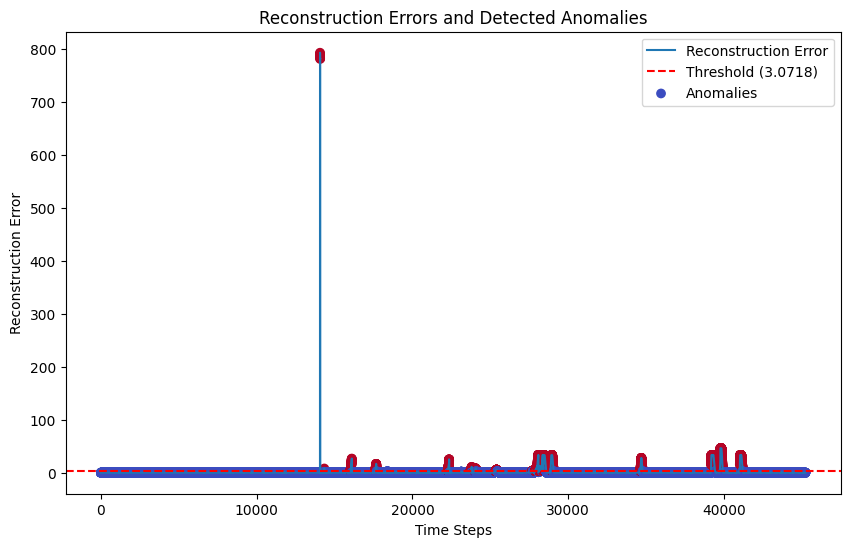

In [30]:
# Example usage for u5_s01_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_s01_turbine_data_preprocessed = preprocess_test_data(u5_s01_equil_turbine, u5_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_s01_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomaly s02 :

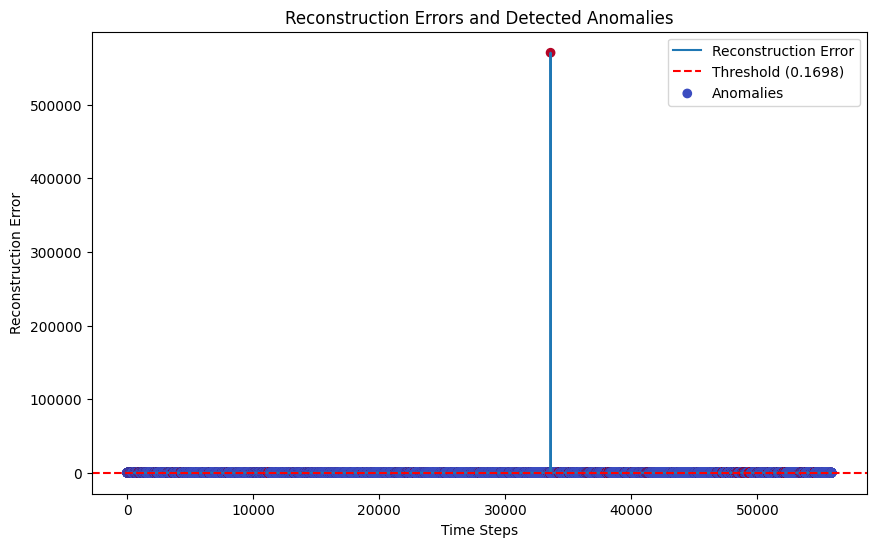

In [31]:
# Example usage for u5_s02_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_s02_turbine_data_preprocessed = preprocess_test_data(u5_s02_equil_turbine, u5_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_s02_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for test anomalies : 

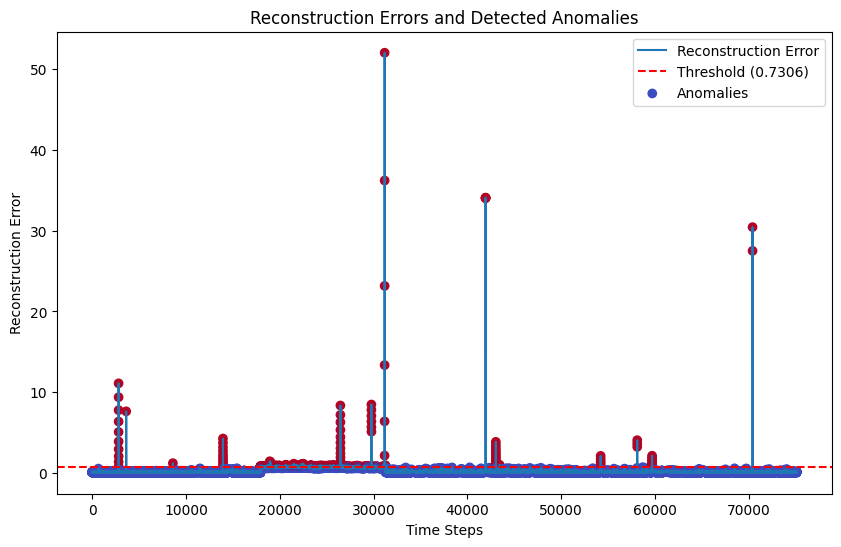

In [33]:
# Example usage for u5_test_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_test_turbine_data_preprocessed = preprocess_test_data(u5_test_equil_turbine, u5_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_test_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## for u5_train_equil_Pump 

In [34]:
# Preprocess u5_train_equil_pump
u5_train_pump_data, scaler = preprocess_data_fast(u5_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u5_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u5_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

Epoch 1/20, Train Loss: 0.1089, Validation Loss: 0.0865
Epoch 2/20, Train Loss: 0.2250, Validation Loss: 0.1171
Epoch 3/20, Train Loss: 0.1149, Validation Loss: 0.1369
Epoch 4/20, Train Loss: 0.1700, Validation Loss: 0.2011
Epoch 5/20, Train Loss: 0.2102, Validation Loss: 0.3243
Epoch 6/20, Train Loss: 0.2558, Validation Loss: 0.2501
Epoch 7/20, Train Loss: 0.2368, Validation Loss: 0.2424
Epoch 8/20, Train Loss: 0.2403, Validation Loss: 0.2420
Epoch 9/20, Train Loss: 0.2376, Validation Loss: 0.2402
Epoch 10/20, Train Loss: 0.2377, Validation Loss: 0.2422
Epoch 11/20, Train Loss: 0.2365, Validation Loss: 0.2454
Epoch 12/20, Train Loss: 0.2435, Validation Loss: 0.2507
Epoch 13/20, Train Loss: 0.2451, Validation Loss: 0.2473
Epoch 14/20, Train Loss: 0.2433, Validation Loss: 0.2552
Epoch 15/20, Train Loss: 0.2476, Validation Loss: 0.2426
Epoch 16/20, Train Loss: 0.2358, Validation Loss: 0.2415
Epoch 17/20, Train Loss: 0.2449, Validation Loss: 0.2730
Epoch 18/20, Train Loss: 0.4193, Validat

#### For Synthetic anomaly s01

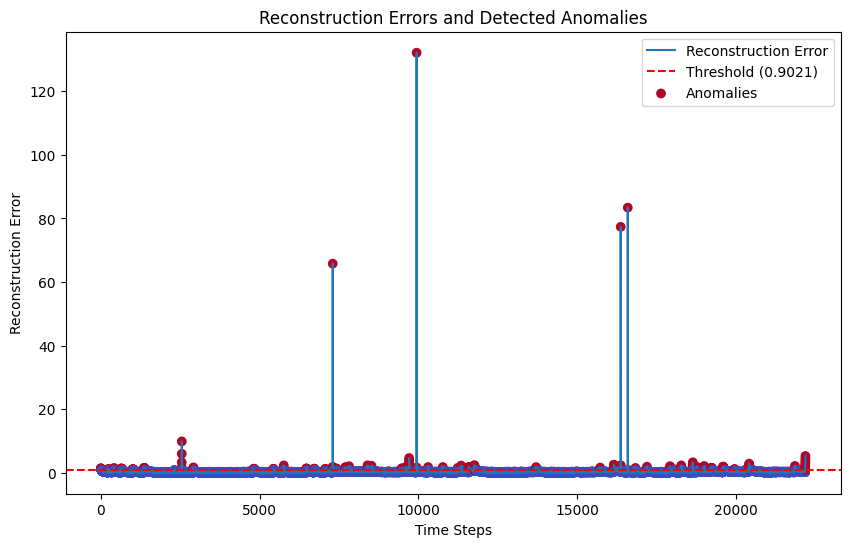

In [35]:
# Example usage for u5_s01_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_s01_pump_data_preprocessed = preprocess_test_data(u5_s01_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_s01_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomalies s02 : 

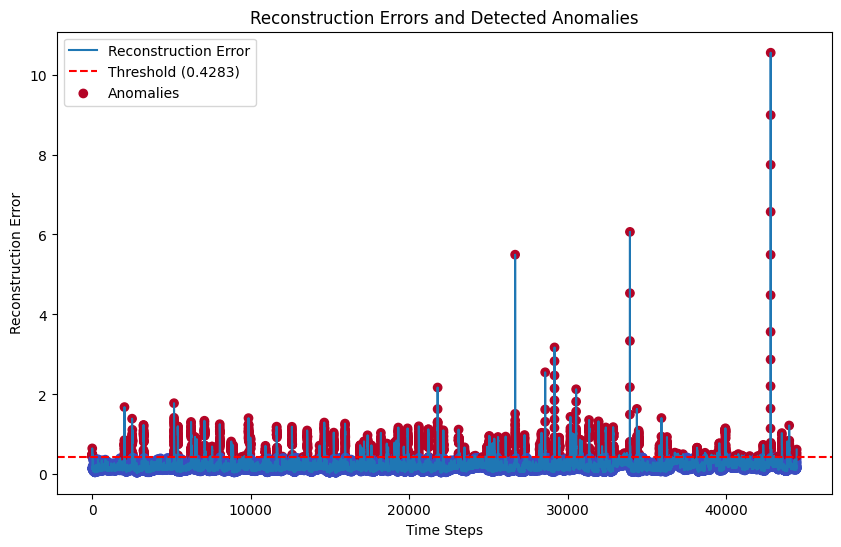

In [36]:
# Example usage for u5_s02_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_s02_pump_data_preprocessed = preprocess_test_data(u5_s02_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_s02_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### For Test data set 

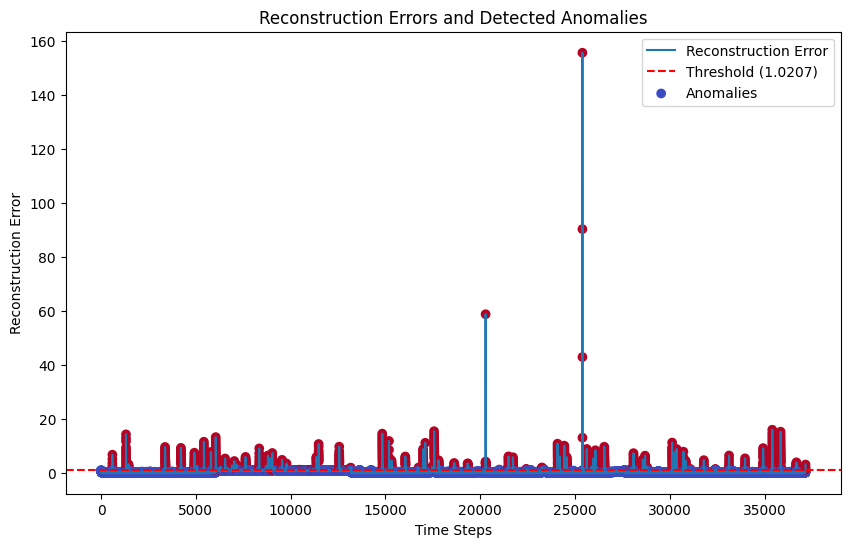

In [37]:
# Example usage for u5_test_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_test_pump_data_preprocessed = preprocess_test_data(u5_test_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_test_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## For u6_train_equil_turbine

In [38]:
# Preprocess u6_train_equil_turbine
u6_train_turbine_data, scaler = preprocess_data_fast(u6_train_equil_turbine)

# Train-validation split
train_tensor, val_tensor = train_test_split(u6_train_turbine_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u6_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

Epoch 1/20, Train Loss: 0.0558, Validation Loss: 0.0523
Epoch 2/20, Train Loss: 0.0590, Validation Loss: 0.0545
Epoch 3/20, Train Loss: 0.0684, Validation Loss: 0.0637
Epoch 4/20, Train Loss: 0.1775, Validation Loss: 0.0930
Epoch 5/20, Train Loss: 0.1411, Validation Loss: 0.1662
Epoch 6/20, Train Loss: 0.1625, Validation Loss: 0.1682
Epoch 7/20, Train Loss: 0.3831, Validation Loss: 0.9031
Epoch 8/20, Train Loss: 0.8985, Validation Loss: 0.9028
Epoch 9/20, Train Loss: 0.8984, Validation Loss: 0.9028
Epoch 10/20, Train Loss: 0.8984, Validation Loss: 0.9034
Epoch 11/20, Train Loss: 0.8985, Validation Loss: 0.9029
Epoch 12/20, Train Loss: 0.8984, Validation Loss: 0.9038
Epoch 13/20, Train Loss: 0.8984, Validation Loss: 0.9028
Epoch 14/20, Train Loss: 0.8985, Validation Loss: 0.9032
Epoch 15/20, Train Loss: 0.8984, Validation Loss: 0.9028
Epoch 16/20, Train Loss: 0.8984, Validation Loss: 0.9030
Epoch 17/20, Train Loss: 0.8985, Validation Loss: 0.9029
Epoch 18/20, Train Loss: 0.8984, Validat

#### Synthetic anomaly s01 :

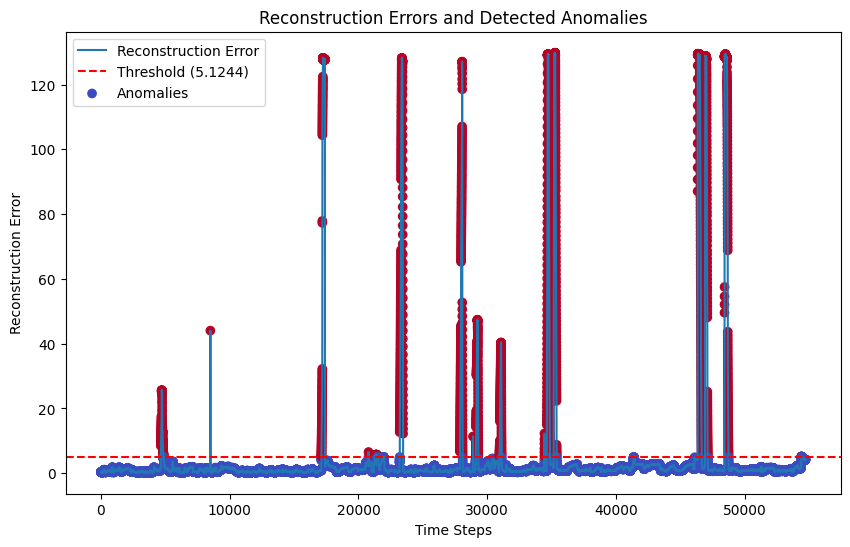

In [39]:
# Example usage for u6_s01_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_s01_turbine_data_preprocessed = preprocess_test_data(u6_s01_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_s01_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### Synthetic anomaly s02 : 

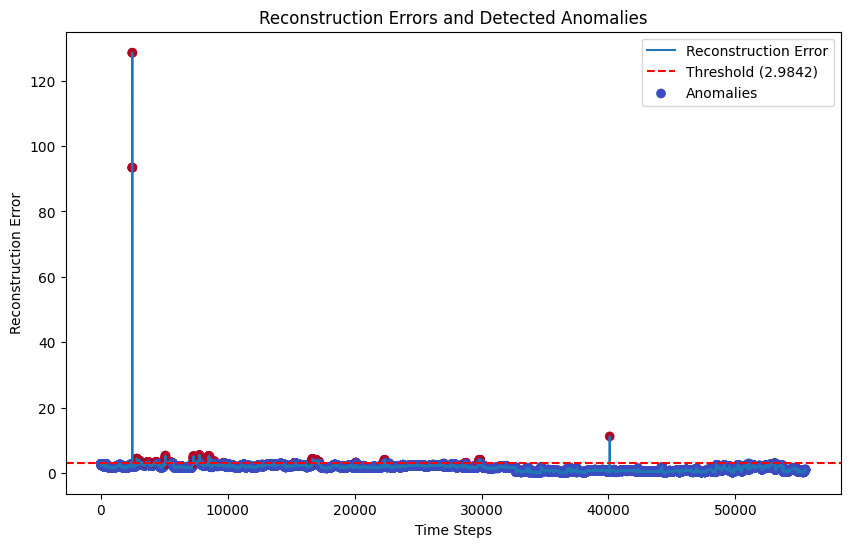

In [40]:
# Example usage for u6_s02_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_s02_turbine_data_preprocessed = preprocess_test_data(u6_s02_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_s02_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

#### For Test data set : 

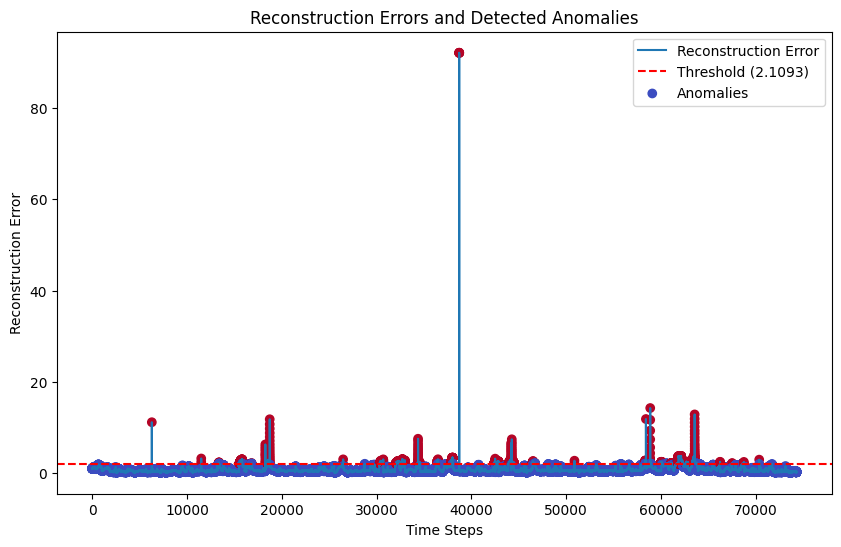

In [41]:
# Example usage for u6_test_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_test_turbine_data_preprocessed = preprocess_test_data(u6_test_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_test_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

#### for u6_train_equil_pump

In [42]:
# Preprocess u6_train_equil_pump
u6_train_pump_data, scaler = preprocess_data_fast(u6_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u6_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u6_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

Epoch 1/20, Train Loss: 0.1146, Validation Loss: 0.0748
Epoch 2/20, Train Loss: 0.0813, Validation Loss: 0.0654
Epoch 3/20, Train Loss: 0.0737, Validation Loss: 0.0590
Epoch 4/20, Train Loss: 0.0781, Validation Loss: 0.0635
Epoch 5/20, Train Loss: 0.0793, Validation Loss: 0.1010
Epoch 6/20, Train Loss: 0.1037, Validation Loss: 0.0883
Epoch 7/20, Train Loss: 0.0796, Validation Loss: 0.0724
Epoch 8/20, Train Loss: 0.0745, Validation Loss: 0.0765
Epoch 9/20, Train Loss: 0.0657, Validation Loss: 0.0592
Epoch 10/20, Train Loss: 0.0686, Validation Loss: 0.0623
Epoch 11/20, Train Loss: 0.0601, Validation Loss: 0.0738
Epoch 12/20, Train Loss: 0.1412, Validation Loss: 0.1430
Epoch 13/20, Train Loss: 0.1261, Validation Loss: 0.1108
Epoch 14/20, Train Loss: 0.1097, Validation Loss: 0.1149
Epoch 15/20, Train Loss: 0.1130, Validation Loss: 0.1195
Epoch 16/20, Train Loss: 0.1101, Validation Loss: 0.1126
Epoch 17/20, Train Loss: 0.1128, Validation Loss: 0.1136
Epoch 18/20, Train Loss: 0.1128, Validat

#### for synthetic anomaly s01 : 

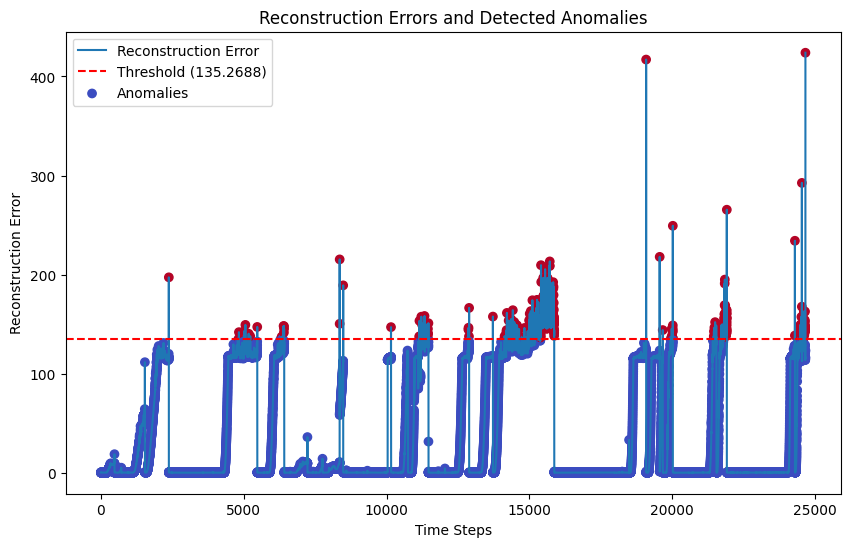

In [43]:
# Example usage for u6_s01_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_s01_pump_data_preprocessed = preprocess_test_data(u6_s01_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_s01_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomaly s02 :

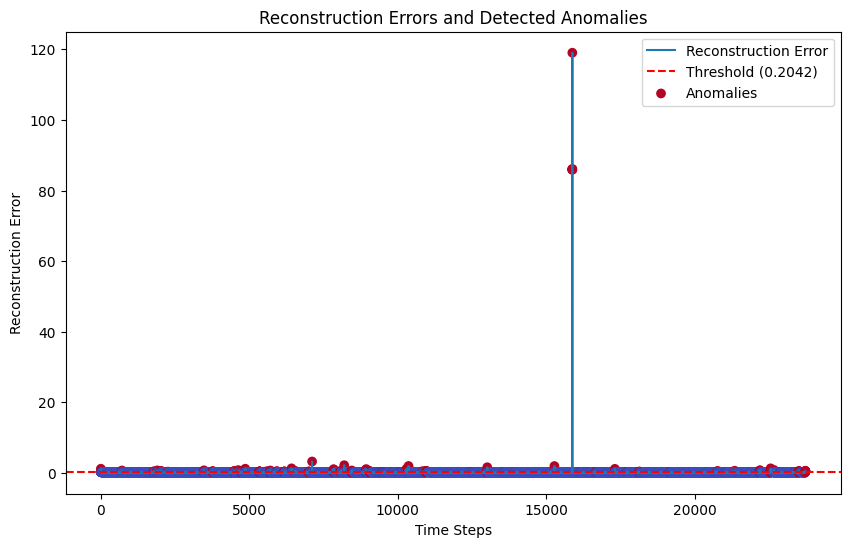

In [44]:
# Example usage for u6_s02_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_s02_pump_data_preprocessed = preprocess_test_data(u6_s02_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_s02_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for Test dataset: 


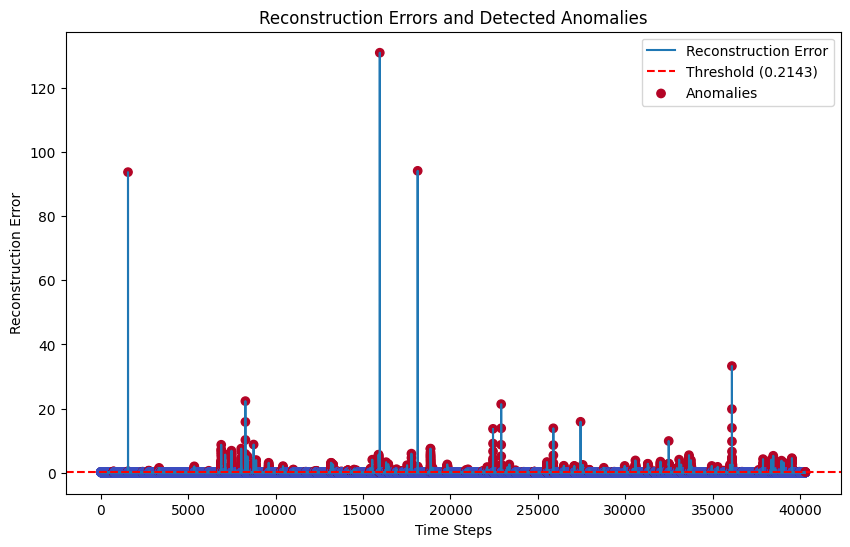

In [45]:
# Example usage for u6_test_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_test_pump_data_preprocessed = preprocess_test_data(u6_test_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_test_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


Tries with raw features...


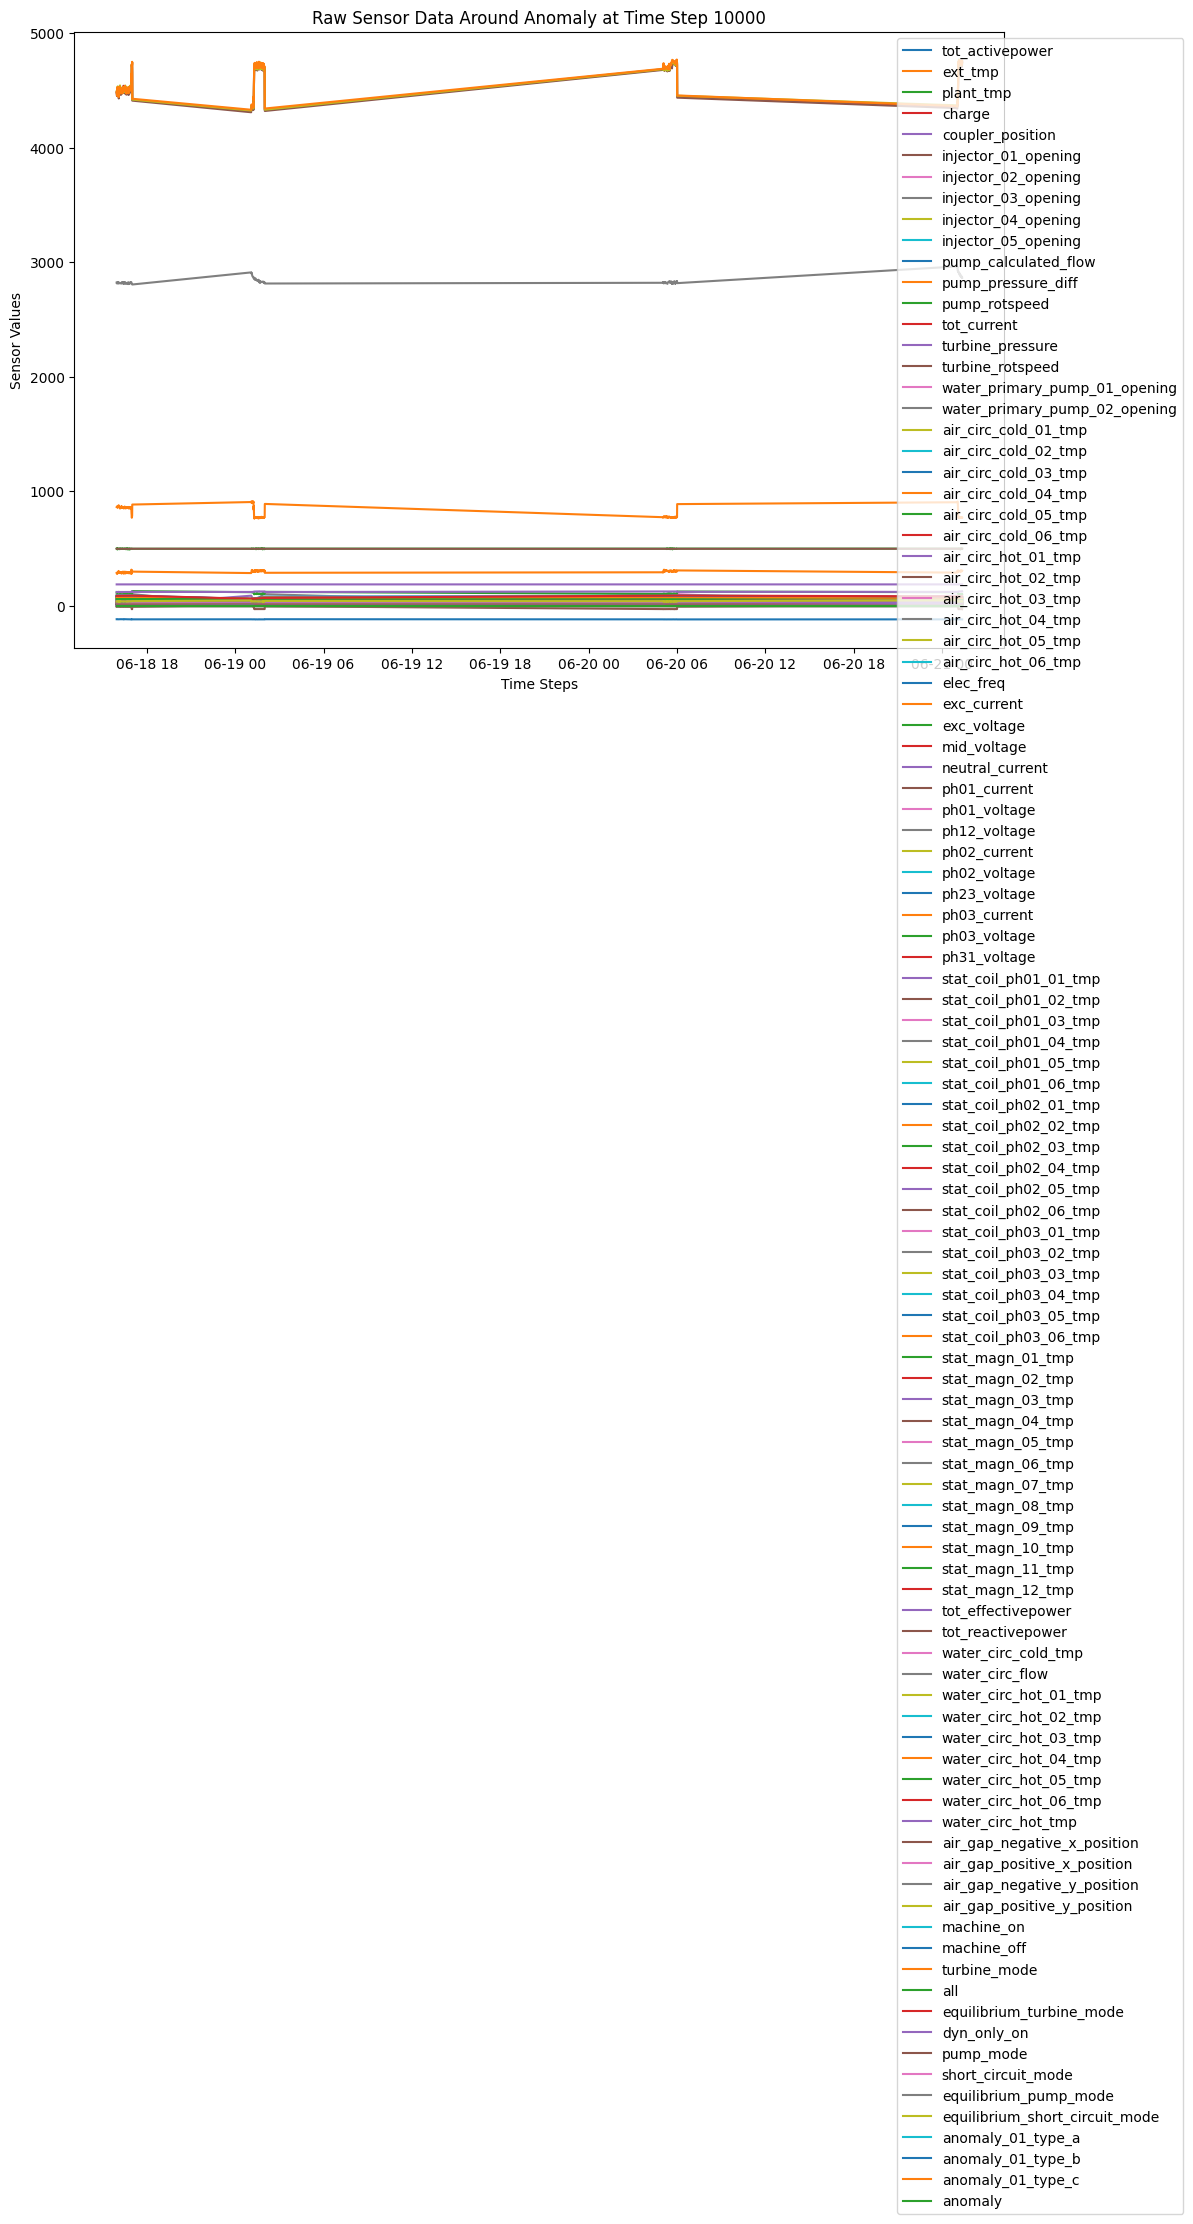

In [46]:
import matplotlib.pyplot as plt

# Define the time step of the anomaly and a window around it
anomaly_time_step = 10000  # Replace this with the actual index of the spike
window_size = 200  # Number of time steps before and after the anomaly
start_idx = max(0, anomaly_time_step - window_size)
end_idx = anomaly_time_step + window_size

# Extract the raw features from the test dataset
raw_features = u6_s01_equil_pump.iloc[start_idx:end_idx]  # Adjust the dataset name if necessary

# Plot raw features
plt.figure(figsize=(12, 8))
for column in raw_features.columns:
    plt.plot(raw_features.index, raw_features[column], label=column)

plt.title(f"Raw Sensor Data Around Anomaly at Time Step {anomaly_time_step}")
plt.xlabel("Time Steps")
plt.ylabel("Sensor Values")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()


#### identify significant features : 

In [47]:
# Calculate feature-wise reconstruction error for the anomaly
def feature_reconstruction_error(raw_data, reconstruction):
    errors = (raw_data - reconstruction) ** 2  # Element-wise squared error
    mean_feature_errors = errors.mean(axis=0)  # Average error per feature
    return mean_feature_errors

# Assuming raw_features is already preprocessed as a tensor
reconstruction, _ = u6_pump_trained_model(u6_s01_pump_data_preprocessed)
feature_errors = feature_reconstruction_error(u6_s01_pump_data_preprocessed, reconstruction)

# Sort and display the most important features
significant_features = feature_errors.argsort(descending=True)[:5]  # Top 5 contributing features
print("Top Contributing Features:")
print(u6_s01_equil_pump.columns[significant_features])


Top Contributing Features:
Index(['water_primary_pump_01_opening', 'dyn_only_on', 'turbine_rotspeed',
       'turbine_pressure', 'ext_tmp'],
      dtype='object')


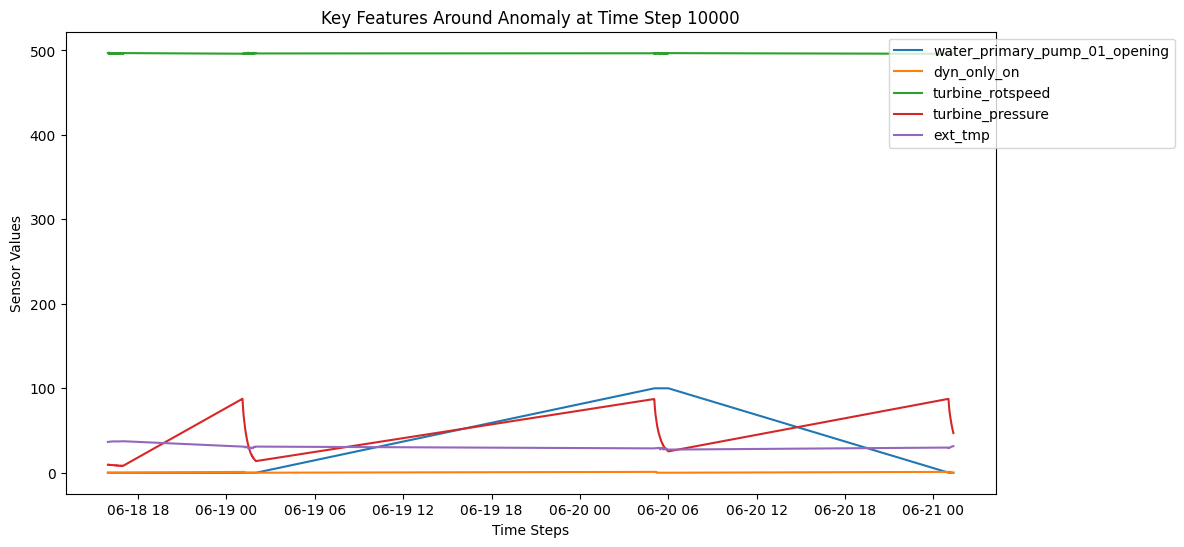

In [50]:
#Focus on those features : 

# Convert significant_features to a list of integers
significant_features = significant_features.tolist()

# Plot only the significant features
plt.figure(figsize=(12, 6))
for column in significant_features:
    plt.plot(raw_features.index, raw_features.iloc[:, column], label=raw_features.columns[column])

plt.title(f"Key Features Around Anomaly at Time Step {anomaly_time_step}")
plt.xlabel("Time Steps")
plt.ylabel("Sensor Values")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()


#### Let's plot all the water_circ_... : why ?I don't knw, but why not.... 

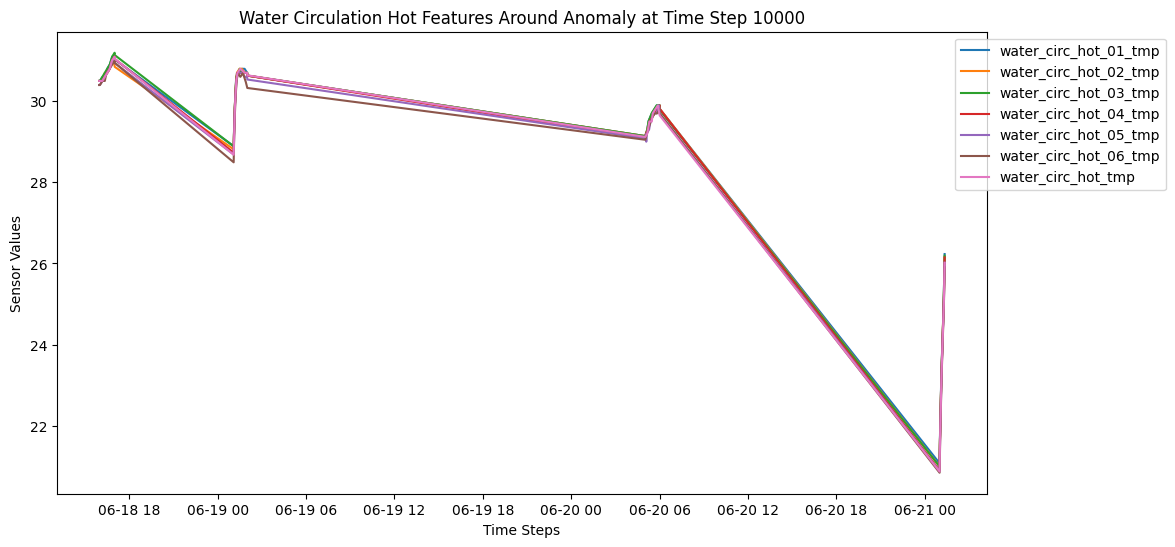

In [55]:
# Define the anomaly time step and window size
anomaly_time_step = 10000  # Replace with the exact time step
narrow_window_size = 200  # Adjust if needed
start_idx = max(0, anomaly_time_step - narrow_window_size)
end_idx = anomaly_time_step + narrow_window_size

# Filter features with "water_circ_hot_" in their names
water_circ_hot_columns = [col for col in u6_s01_equil_pump.columns if "water_circ_hot_" in col]

# Extract data for these features within the specified time window
water_circ_hot_data = u6_s01_equil_pump.iloc[start_idx:end_idx][water_circ_hot_columns]

# Plot the features
plt.figure(figsize=(12, 6))
for col in water_circ_hot_columns:
    plt.plot(water_circ_hot_data.index, water_circ_hot_data[col], label=col)

plt.title(f"Water Circulation Hot Features Around Anomaly at Time Step {anomaly_time_step}")
plt.xlabel("Time Steps")
plt.ylabel("Sensor Values")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()
